## Import libraries

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score

import pandas as pd

from lib.data import constants

## Preprocessing

Process data in different ways depending on if they are numerical or categorical

In [2]:
df = pd.read_csv(constants.PROCESSED_DIR + 'processed_data.csv')

In [3]:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

# input cols
# ['week', 'intensity', 'occupation', 'congestion', 'is_holiday', 'daypart']
# 
# numerical: intensity, occupation and congestion
# categorical: week, is_holiday, daypart

numeric_features = [
    'intensity',
    'occupation',
    'congestion'
]

num_transformer = StandardScaler()

categorical_features = [
    'week',
    'daypart',
    'is_holiday'
]

cat_transformer = OneHotEncoder(handle_unknown='ignore')

input_cols = categorical_features + numeric_features

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', num_transformer, numeric_features),
        ('categorical', cat_transformer, categorical_features)
    ]
)

output_cols = [
    'avg_noise', 
    'p10',
    'p90'
]

df_train = df[input_cols + output_cols].dropna().drop_duplicates() # remove NaN

print('Total data:', df_train.shape)

df_train_2 = df_train.copy(deep=True)

# normalize noise data using min-max scaler
# use all available data
min_max_values = {}

for c in output_cols:

    min_ = df_train_2[c].min()
    max_ = df_train_2[c].max()

    min_max_values[c] = (min_, max_)

    df_train_2[c] = (df_train_2[c] - min_) / (max_ - min_)


Total data: (1173, 9)


### Train some models



In [12]:
X, y = df_train_2[input_cols], df_train_2[output_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

print('Train dataset:', X_train.shape[0])
print('Test dataset:', X_test.shape[0])

Train dataset: 997
Test dataset: 176


In [24]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

mlp_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(hidden_layer_sizes=(150,50), max_iter=500))
])

rf_model = RandomForestRegressor()

# Train and evaluate on test

linear_model.fit(X_train, y_train)
print('Linear model R2 score:', linear_model.score(X_test, y_test))

rf_model.fit(X_train, y_train)
print('Random forest R2 score:', rf_model.score(X_test, y_test))

mlp_model.fit(X_train, y_train)
print('MLP R2 score:', mlp_model.score(X_test, y_test))

Linear model R2 score: 0.921993197688553
Random forest R2 score: 0.9561706407597205
MLP R2 score: 0.9062890834156491


All three models seem to have a high R2 score.

Let's see if we can improve these results with a grid search of hyperparams and CV

In [21]:
from sklearn.model_selection import GridSearchCV, cross_val_score

linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

mlp_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor())
])

rf_model = RandomForestRegressor()

print('Linear model CV scores:', cross_val_score(linear_model, X_train, y_train, scoring='r2', cv=5))

######################################

rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'criterion': ["squared_error", "absolute_error"],
    'max_depth': [2, 3, 4],
}

rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='r2')
rf_grid_search.fit(X_train, y_train) # ~2m

print("Random Forest best params:")
print(rf_grid_search.best_params_)

print(f"CV R2 score: {rf_grid_search.best_score_:.3f}")

######################################

mlp_param_grid = {
    'model__hidden_layer_sizes': [(150,50), (200, 100), (250, 150, 50), (300, 200, 100)],
    'model__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'model__learning_rate_init': [0.001, 0.0001, 0.01]
}

mlp_grid_search = GridSearchCV(mlp_model, mlp_param_grid, cv=5, scoring='r2')
mlp_grid_search.fit(X_train, y_train) # ~5m

print("MLP best params:")
print(mlp_grid_search.best_params_)

print(f"CV R2 score: {mlp_grid_search.best_score_:.3f}")


Linear model CV scores: [0.87747776 0.89988492 0.90147513 0.90672168 0.88487993]
Random Forest best params:
{'criterion': 'absolute_error', 'max_depth': 4, 'n_estimators': 200}
CV R2 score: 0.925
MLP best params:
{'model__hidden_layer_sizes': (250, 150, 50), 'model__learning_rate': 'invscaling', 'model__learning_rate_init': 0.01}
CV R2 score: 0.913


Check their scores on test dataset

In [23]:
print('Random forest R2 score:', rf_grid_search.score(X_test, y_test))
print('MLP R2 score:', mlp_grid_search.score(X_test, y_test))

Random forest R2 score: 0.9415087959705626
MLP R2 score: 0.9362963457578001


It seems that there is no overfitting, so, let's see which model fits all data better

In [26]:
final_linear_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

final_mlp_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(hidden_layer_sizes=(250,150,50), learning_rate='invscaling', learning_rate_init=0.01))
])

final_rf_model = RandomForestRegressor(criterion='absolute_error', max_depth=4, n_estimators=200)

final_linear_model.fit(X, y)
print('Linear model R2 score:', final_linear_model.score(X, y))

final_rf_model.fit(X, y)
print('Random forest R2 score:', final_rf_model.score(X, y))

final_mlp_model.fit(X, y)
print('MLP R2 score:', final_mlp_model.score(X, y))

Linear model R2 score: 0.9110059993576914
Random forest R2 score: 0.9393538586406082
MLP R2 score: 0.9598444682647972


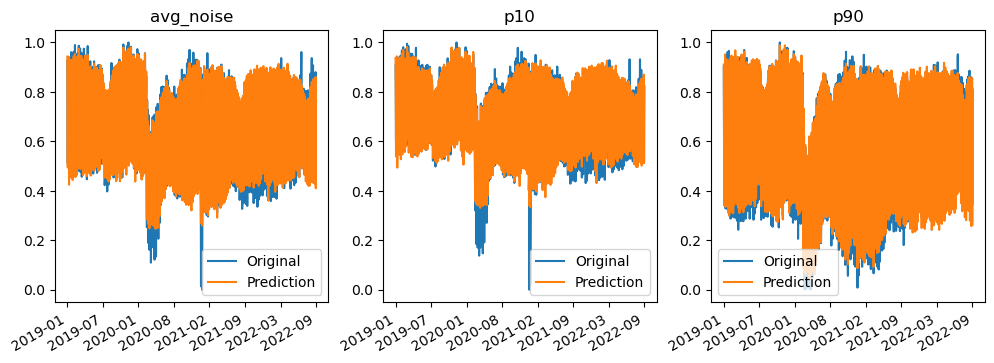

In [30]:
import matplotlib.pyplot as plt

import numpy as np

predictions = pd.DataFrame(final_mlp_model.predict(X), columns=output_cols)
predictions = pd.concat([X, predictions], axis=1)

ind = np.round(np.linspace(0, df.shape[0]-1, 8)).astype(int)
years_weeks = df['year_month'].values[ind]

_, axs = plt.subplots(1,3,figsize=(12,4))
for i, c in enumerate(output_cols):
    plt.subplot(1,3,i+1)
    # aux_2.set_index(['year', 'month', 'day'])[c].plot(rot=45)
    df_train_2[c].plot(label='Original')
    predictions[c].plot(label='Prediction')

    plt.xticks(df.index[ind], years_weeks)
    plt.gcf().autofmt_xdate()

    plt.legend(loc='best')
    plt.title(c)
plt.show()

In [35]:
from joblib import dump, load
import os

if not os.path.exists(constants.MODEL_DIR):
    os.mkdir(constants.MODEL_DIR)

dump(final_mlp_model, constants.MODEL_DIR + 'trained_model.joblib')

dump(min_max_values, constants.MODEL_DIR + 'norm_values_output.joblib')

# test if the model has been loaded corrected
loaded_model = load(constants.MODEL_DIR + 'trained_model.joblib')

loaded_model.score(X, y)

0.9598444682647972